# Coronavirus
Statistics about coronavirus in Czechia.  
Filip Gregor, 2020 

In [5]:
tests = "https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/nakazeni-vyleceni-umrti-testy.csv"
daily_cases = "https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/kraj-okres-nakazeni-vyleceni-umrti.csv"

Import python libraries

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors

Read the data and save them into panda dataframe.

In [7]:
corona = pd.read_csv(tests)
# Translate column headers into english. 
corona = corona.rename({
    'datum' : 'date',
    'kumulativni_pocet_nakazenych' : 'positive_acc',
    'kumulativni_pocet_vylecenych' : 'cured',
    'kumulativni_pocet_umrti' : 'deaths',
    'kumulativni_pocet_testu' : 'tests',
}, axis = 1)
corona.head()

,date,positive_acc,cured,deaths,tests
0,2020-01-27,0,0,0,20
1,2020-01-28,0,0,0,28
2,2020-01-29,0,0,0,33
3,2020-01-30,0,0,0,34
4,2020-01-31,0,0,0,37


Change the 'date' column into datetime datatype, sort values by date and reset indexes.

In [8]:
# Convert date to datetype 
corona['date'] = pd.to_datetime(corona['date'], format='%Y-%m-%d')
# Sort values by date and reset indexes
corona.sort_values('date')
corona = corona.reset_index(drop=True)
corona.tail()

,date,positive_acc,cured,deaths,tests
186,2020-07-31,16562,11720,379,699276
187,2020-08-01,16686,11743,381,703929
188,2020-08-02,16787,11758,383,706564
189,2020-08-03,16996,11823,385,713963
190,2020-08-04,17285,11870,387,722003


Create new column with daily cases and daily tests, also one with total cases at one time(total_acc - cured).

In [9]:
corona['positive_curr'] = corona['positive_acc'] - corona['cured']
corona['daily_positives'] = corona['positive_acc'] - corona['positive_acc'].shift(1)
corona['daily_tests'] = corona['tests'] - corona['tests'].shift(1)
corona.tail()

,date,positive_acc,cured,deaths,tests,positive_curr,daily_positives,daily_tests
186,2020-07-31,16562,11720,379,699276,4842,231.0,8118.0
187,2020-08-01,16686,11743,381,703929,4943,124.0,4653.0
188,2020-08-02,16787,11758,383,706564,5029,101.0,2635.0
189,2020-08-03,16996,11823,385,713963,5173,209.0,7399.0
190,2020-08-04,17285,11870,387,722003,5415,289.0,8040.0


In [10]:
corona_Pmask = corona['daily_positives'] > 0

# Count how many leading rows have 0 cases, stop when we encounter a row that has cases.
count = 0
for x in corona_Pmask:
    if x:
        break
    count += 1
    
corona = corona.iloc[count:]
corona = corona[:-1]
corona = corona.reset_index(drop=True)
display(corona)

,date,positive_acc,cured,deaths,tests,positive_curr,daily_positives,daily_tests
0,2020-03-01,3,0,0,211,3,3.0,11.0
1,2020-03-02,3,0,0,262,3,0.0,51.0
2,2020-03-03,5,0,0,340,5,2.0,78.0
3,2020-03-04,6,0,0,407,6,1.0,67.0
4,2020-03-05,9,0,0,483,9,3.0,76.0
...,...,...,...,...,...,...,...,...
151,2020-07-30,16331,11659,378,691158,4672,250.0,7528.0
152,2020-07-31,16562,11720,379,699276,4842,231.0,8118.0
153,2020-08-01,16686,11743,381,703929,4943,124.0,4653.0
154,2020-08-02,16787,11758,383,706564,5029,101.0,2635.0


# Simple Graphs

### Positive cases

Text(0.5, 1.0, 'Positive cases')

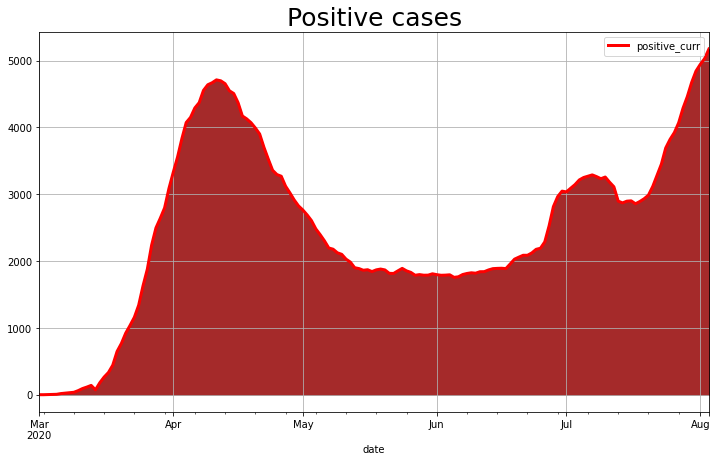

In [11]:
ax = corona.plot(x='date', y='positive_curr', figsize=(12,7), grid=True, lw=3, color='red')

# Pandas does not convert pandas series of datetime64 conversion, so matplotlib does not recognize
# it, thats why we're creating a numpy array, source: https://stackoverflow.com/questions/29329725/pandas-and-matplotlib-fill-between-vs-datetime64
d = corona['date'].values

ax.fill_between(d,  0, corona['positive_curr'], color='brown')
ax.set_title("Positive cases", fontsize=25) 

### Tests done.

Text(0.5, 1.0, 'Tests done')

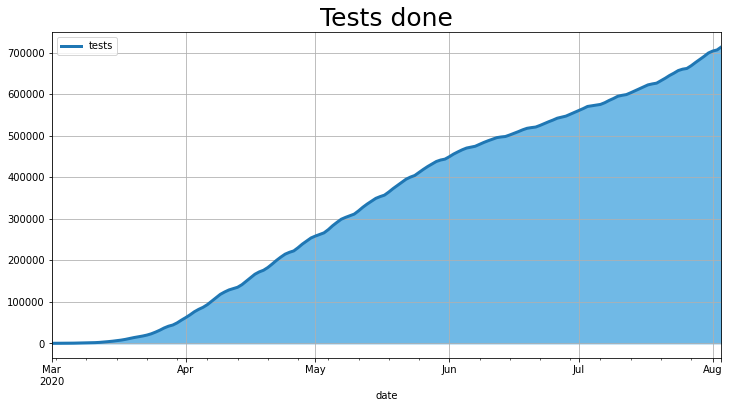

In [12]:
ax = corona.plot(x='date', y='tests', figsize=(12,6), grid=True, lw=3)

ax.fill_between(d, 0, corona['tests'], color='#70b9e6')
ax.set_title('Tests done', fontsize=25)

<Figure size 1120x480 with 0 Axes>

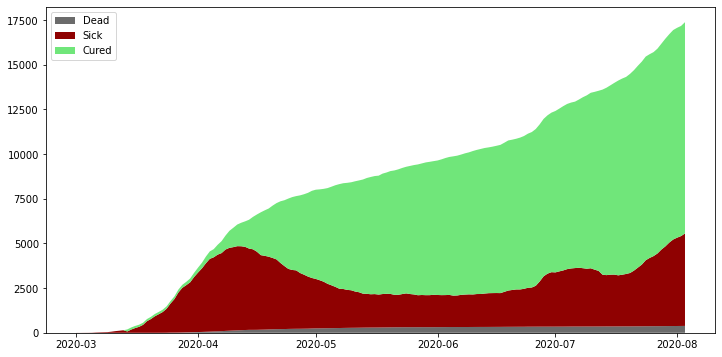

In [26]:
colors = ['#6b6b6b','#8f0101','#70e67a']
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 6), dpi=80)
fig, ax = plt.subplots(figsize=(12,6))
ax.stackplot(d, corona['deaths'], corona['positive_curr'], corona['cured'], labels=('Dead', 'Sick', 'Cured'), colors=colors)
ax.legend(loc='upper left')
mplcursors.cursor(hover=True)
plt.show()